# Data Preprocessing

In [9]:
# 라이브러리 호출
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import random
from sklearn.preprocessing import LabelEncoder


# 시드값 고정
seed = 9
random.seed(seed)
np.random.seed(seed)

# 나이대 맵핑
def age_map(x: int) -> int:
    x = int(x)
    if x < 20:
        return 1
    elif x >= 20 and x < 30:
        return 2
    elif x >= 30 and x < 40:
        return 3
    elif x >= 40 and x < 50:
        return 4
    elif x >= 50 and x < 60:
        return 5
    else:
        return 6

def data_processing(train,test,sub,book,user):
    ### 데이터 전처리 부분
    # 아이디 값 인덱싱 ~ 보기 편하고 이용하기 편하게 ~ data leakage가 고려되지 않는 책 아이디(isbn)와 유저 아이디에 대해서
    ids = pd.concat([train['user_id'], sub['user_id']]).unique()
    isbns = pd.concat([train['isbn'], sub['isbn']]).unique()

    idx2user = {idx:id for idx, id in enumerate(ids)}
    idx2isbn = {idx:isbn for idx, isbn in enumerate(isbns)}

    user2idx = {id:idx for idx, id in idx2user.items()}
    isbn2idx = {isbn:idx for idx, isbn in idx2isbn.items()}

    train['user_id'] = train['user_id'].map(user2idx)
    sub['user_id'] = sub['user_id'].map(user2idx)
    test['user_id'] = test['user_id'].map(user2idx)
    user['user_id'] = user['user_id'].map(user2idx)

    train['isbn'] = train['isbn'].map(isbn2idx)
    sub['isbn'] = sub['isbn'].map(isbn2idx)
    test['isbn'] = test['isbn'].map(isbn2idx)
    book['isbn'] = book['isbn'].map(isbn2idx)

    ### 지역 설정
    # 지역의 경우 세세한 지역보다는 간단한 국가 정도만 사용
    user['location_city'] = user['location'].apply(lambda x: x.split(',')[0])
    user['location_state'] = user['location'].apply(lambda x: x.split(',')[1])
    user['location_country'] = user['location'].apply(lambda x: x.split(',')[2])
    user = user.drop(['location'], axis=1)


    ### 각 train 및 test별로 라벨 인덱싱이 필요한 경우 ~ data leakage 고려되야하는 부분 ~ 인덱싱 및 나이 통계치 확인                            
    ratings = pd.concat([train, test]).reset_index(drop=True)

    # 인덱싱 처리된 데이터 조인
    context_df = ratings.merge(user, on='user_id', how='left').merge(book[['isbn', 'category', 'publisher', 'language', 'book_author']], on='isbn', how='left')
    train_df = train.merge(user, on='user_id', how='left').merge(book[['isbn', 'category', 'publisher', 'language', 'book_author']], on='isbn', how='left')
    test_df = test.merge(user, on='user_id', how='left').merge(book[['isbn', 'category', 'publisher', 'language', 'book_author']], on='isbn', how='left')
       # 인덱싱 처리
    loc_city2idx = {v:k for k,v in enumerate(context_df['location_city'].unique())}
    loc_state2idx = {v:k for k,v in enumerate(context_df['location_state'].unique())}
    loc_country2idx = {v:k for k,v in enumerate(context_df['location_country'].unique())}

    train_df['location_city'] = train_df['location_city'].map(loc_city2idx)
    train_df['location_state'] = train_df['location_state'].map(loc_state2idx)
    train_df['location_country'] = train_df['location_country'].map(loc_country2idx)
    test_df['location_city'] = test_df['location_city'].map(loc_city2idx)
    test_df['location_state'] = test_df['location_state'].map(loc_state2idx)
    test_df['location_country'] = test_df['location_country'].map(loc_country2idx)

    train_df['age'] = train_df['age'].fillna(int(train_df['age'].mean()))
    train_df['age'] = train_df['age'].apply(age_map)
    test_df['age'] = test_df['age'].fillna(int(test_df['age'].mean()))
    test_df['age'] = test_df['age'].apply(age_map)

    # book 파트 인덱싱
    category2idx = {v:k for k,v in enumerate(context_df['category'].unique())}
    publisher2idx = {v:k for k,v in enumerate(context_df['publisher'].unique())}
    language2idx = {v:k for k,v in enumerate(context_df['language'].unique())}
    author2idx = {v:k for k,v in enumerate(context_df['book_author'].unique())}

    train_df['category'] = train_df['category'].map(category2idx)
    train_df['publisher'] = train_df['publisher'].map(publisher2idx)
    train_df['language'] = train_df['language'].map(language2idx)
    train_df['book_author'] = train_df['book_author'].map(author2idx)
    test_df['category'] = test_df['category'].map(category2idx)
    test_df['publisher'] = test_df['publisher'].map(publisher2idx)
    test_df['language'] = test_df['language'].map(language2idx)
    test_df['book_author'] = test_df['book_author'].map(author2idx)

    # 필드 차원 수 정해주기
    field_dim = np.array([len(user2idx), len(isbn2idx),
                            6, len('loc_city2idx'), len('loc_state2idx'), len('loc_country2idx'),
                            len('category2idx'), len('publisher2idx'), len('language2idx'), len('author2idx')], dtype=np.uint32)

        
    # 나중에 인덱싱한거 다시 되돌리기 용 및 기타 데이터 다 저장해서 넘기기 ~ data['train'] 이런식으로 조회 및 타 데이터 추가 가능하게
    data = {
            'train' : train_df,
            'test' : test_df.drop(['rating'], axis=1),
            'user':user,
            'book':book,
            'sub':sub,
            'idx2user':idx2user,
            'idx2isbn':idx2isbn,
            'user2idx':user2idx,
            'isbn2idx':isbn2idx,  
            'field_dim' : field_dim   
            }

    return data 

def context_data_split(data):
    X_train, X_valid, y_train, y_valid = train_test_split(
                                                        data['train'].drop(['rating'], axis=1),
                                                        data['train']['rating'],
                                                        test_size=0.2,
                                                        random_state=seed,
                                                        shuffle=True
                                                        )
    data['X_train'], data['X_valid'], data['y_train'], data['y_valid'] = X_train, X_valid, y_train, y_valid

    return data

def stratified_kfold(data,n):
    skf = StratifiedKFold(n_splits= 5, shuffle=True, random_state=seed)
    counts = 0
    for train_index, valid_index in skf.split(data['train'].drop(['rating'], axis=1),data['train']['rating']):
        if counts == n:
            data['X_train'], data['y_train'] = data['train'].drop(['rating'], axis=1).loc[train_index], data['train']['rating'].loc[train_index]
            data['X_valid'], data['y_valid'] = data['train'].drop(['rating'], axis=1).loc[valid_index], data['train']['rating'].loc[valid_index]
            break
        else:
            counts += 1
        
    return data

# RandomForestRegressor with K-Fold

In [10]:
import os
import time
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

book = pd.read_csv('data/books_word2vec.csv')
user = pd.read_csv('data/users.csv')
train = pd.read_csv('data/train_ratings.csv')
test = pd.read_csv('data/test_ratings.csv')
sub = pd.read_csv('data/sample_submission.csv')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def rmse(real: list, predict: list) -> float:
    pred = np.array(predict)
    return np.sqrt(np.mean((real-pred) ** 2))

In [30]:
seed_everything(9)

#### hyperparma search
data = context_data_split(data_processing(train,test,sub,book,user))
#### from Human activity recognization dataset...(len:1만)
# params = {
#     'n_estimators' : [100],
#     'max_depth' : [6,8,10,12],
#     'min_samples_leaf' : [8,12,18],
#     'min_samples_split' : [8,16,20]
# }

params = {
    'n_estimators': [100],
    'max_depth': [12, 15, 20, 25],
    'min_samples_leaf': [5, 8, 10, 12, 15],
    'min_samples_split': [8, 16, 20],
    'max_features': [None,'sqrt'] 
}

model = RandomForestRegressor(random_state=9, n_jobs=-1)
grid_cv = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(data['X_train'], data['y_train'])

print("grid_cv result :", grid_cv.best_params_)
cv_result_df = pd.DataFrame(grid_cv.cv_results_)
print("성능비교표")
print(cv_result_df)

### k-fold
data = data_processing(train,test,sub,book,user)

predicts_list = []
rmse_list = []
for i in  range(5):
    data = stratified_kfold(data,i)
    model = RandomForestRegressor(n_estimators=300, random_state=9, max_depth=grid_cv.best_params_['max_depth'], min_samples_leaf=grid_cv.best_params_['min_samples_leaf'], min_samples_split = grid_cv.best_params_['min_samples_split'], max_features=grid_cv.best_params_['max_features'])
    model.fit(data['X_train'], data['y_train'])
    rfr_preds = model.predict(data['X_valid'])
    rmse_score = rmse(data['y_valid'].tolist(),rfr_preds.tolist())
    print(rmse_score)
    rmse_list.append(rmse_score)
    predicts_list.append(model.predict(data['test']))

sub['rating'] = np.mean(predicts_list, axis=0)

now = time.localtime()
now_date = time.strftime('%Y%m%d', now)
now_hour = time.strftime('%X', now)
save_time = now_date + '_' + now_hour.replace(':', '')
sub.to_csv('{}_{}_{}.csv'.format(save_time,"rfr",sum(rmse_list)/len(rmse_list)), index=False)

grid_cv result : {'max_depth': 25, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 100}
성능비교표
     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       133.541880      0.761257         0.809536        0.115271   
1       134.092963      1.347636         0.681388        0.103577   
2       135.904234      0.560686         0.910952        0.090984   
3       131.865965      1.650828         0.763311        0.086018   
4       133.841039      3.534568         0.762075        0.169840   
..             ...           ...              ...             ...   
115      60.278558      0.847164         1.571792        0.139270   
116      61.198841      1.163823         1.680563        0.122805   
117      60.493262      0.631266         1.478604        0.142846   
118      60.872154      1.118549         1.445166        0.133607   
119      45.032668     16.945475         0.813583        0.315201   

    param_max_depth param_max_features p

Test - user_fillage.csv 사용

In [1]:

# 라이브러리 호출
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import random
from sklearn.preprocessing import LabelEncoder


# 시드값 고정
seed = 9
random.seed(seed)
np.random.seed(seed)

# 나이대 맵핑
def age_map(x: int) -> int:
    x = int(x)
    if x < 20:
        return 1
    elif x >= 20 and x < 30:
        return 2
    elif x >= 30 and x < 40:
        return 3
    elif x >= 40 and x < 50:
        return 4
    elif x >= 50 and x < 60:
        return 5
    else:
        return 6

def data_processing(train,test,sub,book,user):
    ### 데이터 전처리 부분
    # 아이디 값 인덱싱 ~ 보기 편하고 이용하기 편하게 ~ data leakage가 고려되지 않는 책 아이디(isbn)와 유저 아이디에 대해서
    ids = pd.concat([train['user_id'], sub['user_id']]).unique()
    isbns = pd.concat([train['isbn'], sub['isbn']]).unique()

    idx2user = {idx:id for idx, id in enumerate(ids)}
    idx2isbn = {idx:isbn for idx, isbn in enumerate(isbns)}

    user2idx = {id:idx for idx, id in idx2user.items()}
    isbn2idx = {isbn:idx for idx, isbn in idx2isbn.items()}

    train['user_id'] = train['user_id'].map(user2idx)
    sub['user_id'] = sub['user_id'].map(user2idx)
    test['user_id'] = test['user_id'].map(user2idx)
    user['user_id'] = user['user_id'].map(user2idx)

    train['isbn'] = train['isbn'].map(isbn2idx)
    sub['isbn'] = sub['isbn'].map(isbn2idx)
    test['isbn'] = test['isbn'].map(isbn2idx)
    book['isbn'] = book['isbn'].map(isbn2idx)

    # ### 지역 설정
    # # 지역의 경우 세세한 지역보다는 간단한 국가 정도만 사용
    # user['location_city'] = user['location'].apply(lambda x: x.split(',')[0])
    # user['location_state'] = user['location'].apply(lambda x: x.split(',')[1])
    # user['location_country'] = user['location'].apply(lambda x: x.split(',')[2])
    # user = user.drop(['location'], axis=1)


    ### 각 train 및 test별로 라벨 인덱싱이 필요한 경우 ~ data leakage 고려되야하는 부분 ~ 인덱싱 및 나이 통계치 확인                            
    ratings = pd.concat([train, test]).reset_index(drop=True)

    # 인덱싱 처리된 데이터 조인
    context_df = ratings.merge(user, on='user_id', how='left').merge(book[['isbn', 'category', 'publisher', 'language', 'book_author']], on='isbn', how='left')
    train_df = train.merge(user, on='user_id', how='left').merge(book[['isbn', 'category', 'publisher', 'language', 'book_author']], on='isbn', how='left')
    test_df = test.merge(user, on='user_id', how='left').merge(book[['isbn', 'category', 'publisher', 'language', 'book_author']], on='isbn', how='left')
    # 인덱싱 처리
    # loc_city2idx = {v:k for k,v in enumerate(context_df['location_city'].unique())}
    # loc_state2idx = {v:k for k,v in enumerate(context_df['location_state'].unique())}
    loc_country2idx = {v:k for k,v in enumerate(context_df['location_country'].unique())}

    # train_df['location_city'] = train_df['location_city'].map(loc_city2idx)
    # train_df['location_state'] = train_df['location_state'].map(loc_state2idx)
    train_df['location_country'] = train_df['location_country'].map(loc_country2idx)
    # test_df['location_city'] = test_df['location_city'].map(loc_city2idx)
    # test_df['location_state'] = test_df['location_state'].map(loc_state2idx)
    test_df['location_country'] = test_df['location_country'].map(loc_country2idx)

    train_df['age'] = train_df['age'].fillna(int(train_df['age'].mean()))
    train_df['age'] = train_df['age'].apply(age_map)
    test_df['age'] = test_df['age'].fillna(int(test_df['age'].mean()))
    test_df['age'] = test_df['age'].apply(age_map)

    # book 파트 인덱싱
    category2idx = {v:k for k,v in enumerate(context_df['category'].unique())}
    publisher2idx = {v:k for k,v in enumerate(context_df['publisher'].unique())}
    language2idx = {v:k for k,v in enumerate(context_df['language'].unique())}
    author2idx = {v:k for k,v in enumerate(context_df['book_author'].unique())}

    train_df['category'] = train_df['category'].map(category2idx)
    train_df['publisher'] = train_df['publisher'].map(publisher2idx)
    train_df['language'] = train_df['language'].map(language2idx)
    train_df['book_author'] = train_df['book_author'].map(author2idx)
    test_df['category'] = test_df['category'].map(category2idx)
    test_df['publisher'] = test_df['publisher'].map(publisher2idx)
    test_df['language'] = test_df['language'].map(language2idx)
    test_df['book_author'] = test_df['book_author'].map(author2idx)

    # 필드 차원 수 정해주기
    # field_dim = np.array([len(user2idx), len(isbn2idx),
    #                         6, len('loc_city2idx'), len('loc_state2idx'), len('loc_country2idx'),
    #                         len('category2idx'), len('publisher2idx'), len('language2idx'), len('author2idx')], dtype=np.uint32)
    field_dim = np.array([len(user2idx), len(isbn2idx), 6, len('loc_country2idx'),len('category2idx'), len('publisher2idx'), len('language2idx'), len('author2idx')], dtype=np.uint32)
        
    # 나중에 인덱싱한거 다시 되돌리기 용 및 기타 데이터 다 저장해서 넘기기 ~ data['train'] 이런식으로 조회 및 타 데이터 추가 가능하게
    data = {
            'train' : train_df,
            'test' : test_df.drop(['rating'], axis=1),
            'user':user,
            'book':book,
            'sub':sub,
            'idx2user':idx2user,
            'idx2isbn':idx2isbn,
            'user2idx':user2idx,
            'isbn2idx':isbn2idx,  
            'field_dim' : field_dim   
            }

    return data 

def context_data_split(data):
    X_train, X_valid, y_train, y_valid = train_test_split(
                                                        data['train'].drop(['rating'], axis=1),
                                                        data['train']['rating'],
                                                        test_size=0.2,
                                                        random_state=seed,
                                                        shuffle=True
                                                        )
    data['X_train'], data['X_valid'], data['y_train'], data['y_valid'] = X_train, X_valid, y_train, y_valid

    return data

def stratified_kfold(data,n):
    skf = StratifiedKFold(n_splits= 5, shuffle=True, random_state=seed)
    counts = 0
    for train_index, valid_index in skf.split(data['train'].drop(['rating'], axis=1),data['train']['rating']):
        if counts == n:
            data['X_train'], data['y_train'] = data['train'].drop(['rating'], axis=1).loc[train_index], data['train']['rating'].loc[train_index]
            data['X_valid'], data['y_valid'] = data['train'].drop(['rating'], axis=1).loc[valid_index], data['train']['rating'].loc[valid_index]
            break
        else:
            counts += 1
        
    return data

In [2]:
import os
import time
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

book = pd.read_csv('data/books_word2vec.csv')
user = pd.read_csv('data/users_fillage.csv')
train = pd.read_csv('data/train_ratings.csv')
test = pd.read_csv('data/test_ratings.csv')
sub = pd.read_csv('data/sample_submission.csv')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def rmse(real: list, predict: list) -> float:
    pred = np.array(predict)
    return np.sqrt(np.mean((real-pred) ** 2))

In [5]:
seed_everything(9)

#### hyperparma search
data = context_data_split(data_processing(train,test,sub,book,user))
#### from Human activity recognization dataset...(len:1만)
# params = {
#     'n_estimators' : [100],
#     'max_depth' : [6,8,10,12],
#     'min_samples_leaf' : [8,12,18],
#     'min_samples_split' : [8,16,20]
# }

params = {
    'n_estimators': [100],
    'max_depth': [12, 15, 20, 25],
    'min_samples_leaf': [5, 8, 10, 12, 15],
    'min_samples_split': [8, 16, 20],
    'max_features': [None,'sqrt'] 
}

model = RandomForestRegressor(random_state=9, n_jobs=-1)
grid_cv = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(data['X_train'], data['y_train'])

print("grid_cv result :", grid_cv.best_params_)
cv_result_df = pd.DataFrame(grid_cv.cv_results_)
print("성능비교표")
print(cv_result_df)

### k-fold
data = data_processing(train,test,sub,book,user)

predicts_list = []
rmse_list = []
for i in  range(5):
    data = stratified_kfold(data,i)
    model = RandomForestRegressor(n_estimators=300, random_state=9, max_depth=grid_cv.best_params_['max_depth'], min_samples_leaf=grid_cv.best_params_['min_samples_leaf'], min_samples_split = grid_cv.best_params_['min_samples_split'], max_features=grid_cv.best_params_['max_features'])
    model.fit(data['X_train'], data['y_train'])
    rfr_preds = model.predict(data['X_valid'])
    rmse_score = rmse(data['y_valid'].tolist(),rfr_preds.tolist())
    print(rmse_score)
    rmse_list.append(rmse_score)
    predicts_list.append(model.predict(data['test']))

sub['rating'] = np.mean(predicts_list, axis=0)

now = time.localtime()
now_date = time.strftime('%Y%m%d', now)
now_hour = time.strftime('%X', now)
save_time = now_date + '_' + now_hour.replace(':', '')
sub.to_csv('{}_{}_{}_fillage.csv'.format(save_time,"rfr",sum(rmse_list)/len(rmse_list)), index=False)

grid_cv result : {'max_depth': 25, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}
성능비교표
     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       104.373001      0.316866         0.595706        0.094517   
1       104.824838      2.098746         0.695945        0.104816   
2       103.182366      0.962718         0.725610        0.038654   
3       104.107167      1.992612         0.774832        0.059302   
4       103.674856      0.700824         0.796461        0.092659   
..             ...           ...              ...             ...   
115      39.063511      0.503701         1.509710        0.049362   
116      38.658776      0.444677         1.406413        0.060679   
117      38.068897      0.430620         1.368010        0.056684   
118      37.554898      0.341719         1.325547        0.097388   
119      30.019086      3.061942         0.643159        0.279187   

    param_max_depth param_max_features 

In [ ]:
# rfr = RandomForestRegressor()
# rfr.fit(X_train, y_train)
# rfr_pred = rfr.predict(x_test)

피처 중요도 시각화

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

seed_everything(9)

### k-fold
data = context_data_split(data_processing(train,test,sub,book,user))

predicts_list = []
rmse_list = []

model = RandomForestRegressor(n_estimators=300, random_state=9, max_depth=25, min_samples_leaf=5, min_samples_split = 20, max_features=None)
model.fit(data['X_train'], data['y_train'])
rfr_preds = model.predict(data['X_valid'])
rmse_score = rmse(data['y_valid'].tolist(),rfr_preds.tolist())
print(rmse_score)
# rmse_list.append(rmse_score)
# predicts_list.append(model.predict(data['test']))


# sub['rating'] = np.mean(predicts_list, axis=0)

# now = time.localtime()
# now_date = time.strftime('%Y%m%d', now)
# now_hour = time.strftime('%X', now)
# save_time = now_date + '_' + now_hour.replace(':', '')
# sub.to_csv('{}_{}_{}.csv'.format(save_time,"rfr",sum(rmse_list)/len(rmse_list)), index=False)

2.246292936282448


In [15]:
feature_scores = pd.Series(model.feature_importances_, index=data['X_train'].columns).sort_values(ascending=False)
feature_scores

user_id             0.208103
isbn                0.160933
location_city       0.150149
book_author         0.137509
publisher           0.120184
location_state      0.111553
category            0.046110
age                 0.028224
location_country    0.028120
language            0.009116
dtype: float64

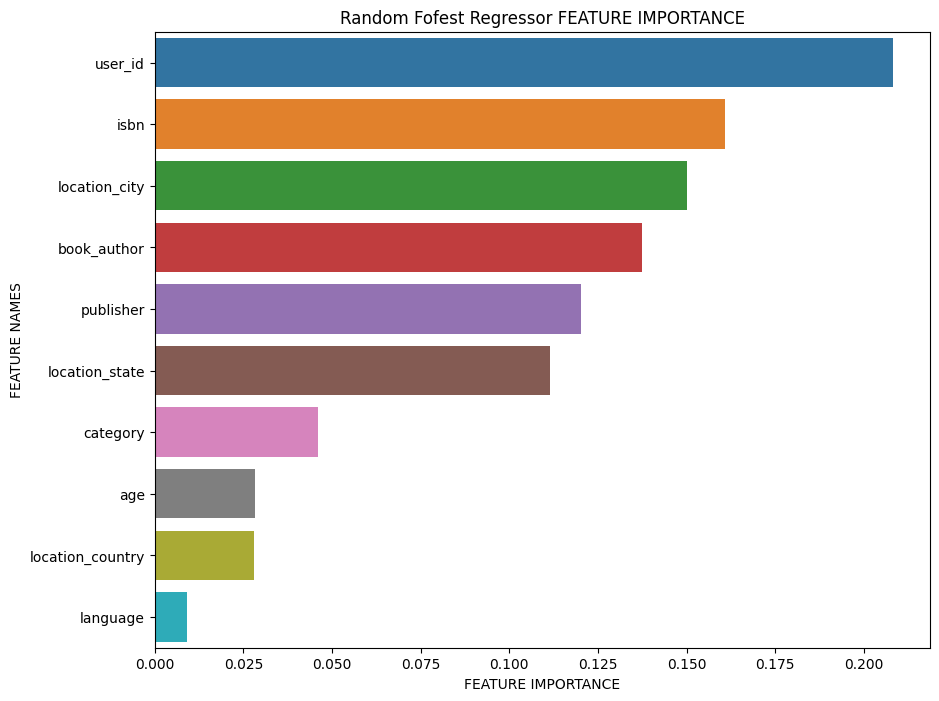

In [20]:
# Creating a seaborn bar plot
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(model.feature_importances_,data['X_train'].columns,'Random Fofest Regressor ')